# Advanced Analytics Project
As part of our Semester 6, we worked on this project that helps us apply our knowledge while analysing Geospatial Data. This project submission is made to Prof Feroz Anwar and the data used has been provided on: https://drive.google.com/drive/folders/12zBcwpfDIrEYvEfdvgGMDVhrctBd8YWM. 
The team consists of 3 members, namely:

- Rithwik Chhugani (BS18BDS008)
- Pratiksha Sharma (BS18BDS010)
- Gautam Sadarangani (BS18BDS015)

For doubts or queries, please contact the team on any of these email addresses: rithwik.bs18bds008@spjain.org, pratiksha.bs18bds010@spjain.org, gautam.bs18bds015@spjain.org

You can also message/call on: +91 8791607009

In [1]:
!pip install pysal
!pip install geopandas

     |████████████████████████████████| 2.4MB 24.5MB/s 
     |████████████████████████████████| 112kB 49.6MB/s 
     |████████████████████████████████| 61kB 9.5MB/s 
     |████████████████████████████████| 61kB 9.4MB/s 
     |████████████████████████████████| 92kB 11.2MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 
     |████████████████████████████████| 215kB 42.6MB/s 
     |████████████████████████████████| 5.7MB 25.4MB/s 
     |████████████████████████████████| 61kB 8.4MB/s 
     |████████████████████████████████| 153kB 47.9MB/s 
     |████████████████████████████████| 235kB 48.0MB/s 
     |████████████████████████████████| 235kB 46.0MB/s 
     |████████████████████████████████| 57.4MB 67kB/s 
     |████████████████████████████████| 1.0MB 42.9MB/s 
     |████████████████████████████████| 1.0MB 51.2MB/s 
     |████████████████████████████████| 2.0MB 54.3MB/s 
     |████████████████████████████████| 19.1MB 1.3MB/s 
    

The notebook is divided in the following sections:

1. Importing necessary libraries
2. Importing the geojson dataset
3. Exploring the data
4. Plotting Heatmap for determining feature correlations
5. Creation of Non-spatial Regression model
6. Investigation of Residuals: Neighborhood wise
7. Investigation of Residuals: Using 1 Nearest Neighbor (KNN=1)
8. Investigation of Residuals: Using 20 Nearest Neighbors (KNN=20)
9. Creation of Spatial Regression model: Addition of Spatial Heterogeneity
10. Conclusion


1. Importing necessary libraries

In [37]:
# for data processing
import numpy as np
import pandas as pd

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# for geospatial analysis
from pysal.model import spreg # Spatial Regression package
from pysal.lib import weights 
from pysal.explore import esda
import geopandas

2. Importing the geojson dataset

In [103]:
df = geopandas.read_file('/content/airbnb_db.geojson')
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6110 entries, 0 to 6109
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   accommodates        6110 non-null   int64   
 1   bathrooms           6110 non-null   float64 
 2   bedrooms            6110 non-null   float64 
 3   beds                6110 non-null   float64 
 4   neighborhood        6110 non-null   object  
 5   pool                6110 non-null   int64   
 6   d2balboa            6110 non-null   float64 
 7   coastal             6110 non-null   int64   
 8   price               6110 non-null   float64 
 9   log_price           6110 non-null   float64 
 10  id                  6110 non-null   int64   
 11  pg_Apartment        6110 non-null   int64   
 12  pg_Condominium      6110 non-null   int64   
 13  pg_House            6110 non-null   int64   
 14  pg_Other            6110 non-null   int64   
 15  pg_Townhouse        6110 non-n

The dataset looks completely clean and does not appear to need pre-processing or cleaning

3. Exploring the data

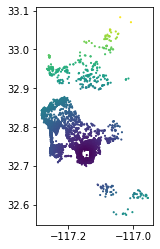

In [80]:
# Distance of our properties from Balboa Park
df.plot('d2balboa', marker='.', s=5)
plt.show()

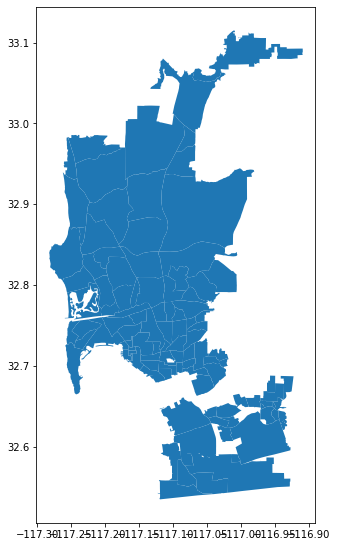

In [102]:
nf = geopandas.read_file('/content/neighbourhoods (1).geojson')
nf['geometry'].plot(marker='.', figsize=(5,20))
plt.show()

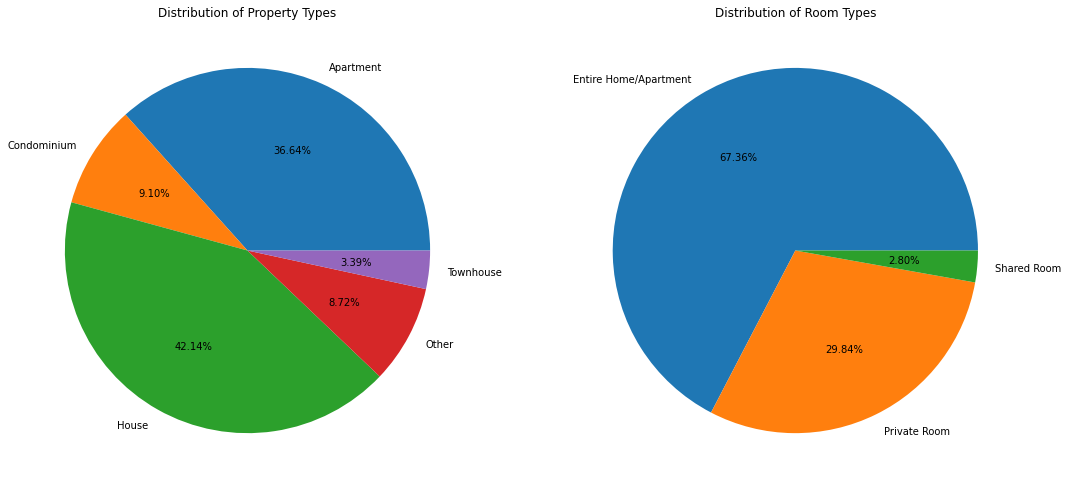

In [81]:
plt.figure(figsize=(18,9))
plt.subplot(1,2,1)
# Property Type
p_type = dict(df[['pg_Apartment', 'pg_Condominium', 'pg_House', 'pg_Other', 'pg_Townhouse']].sum()/6110)
p_type
# plot pie charts
plt.pie(list(p_type.values()),autopct ='%1.2f%%',labels=['Apartment', 'Condominium', 'House', 'Other', 'Townhouse'])
plt.title('Distribution of Property Types')

plt.subplot(1,2,2)
# Property Type
r_type = dict(df[['rt_Entire_home/apt', 'rt_Private_room', 'rt_Shared_room']].sum()/6110)
r_type
# plot pie charts
plt.pie(list(r_type.values()),autopct ='%1.2f%%',labels=['Entire Home/Apartment', 'Private Room', 'Shared Room'])
plt.title('Distribution of Room Types')
plt.show()

4. Plotting Heatmap for determining feature correlations

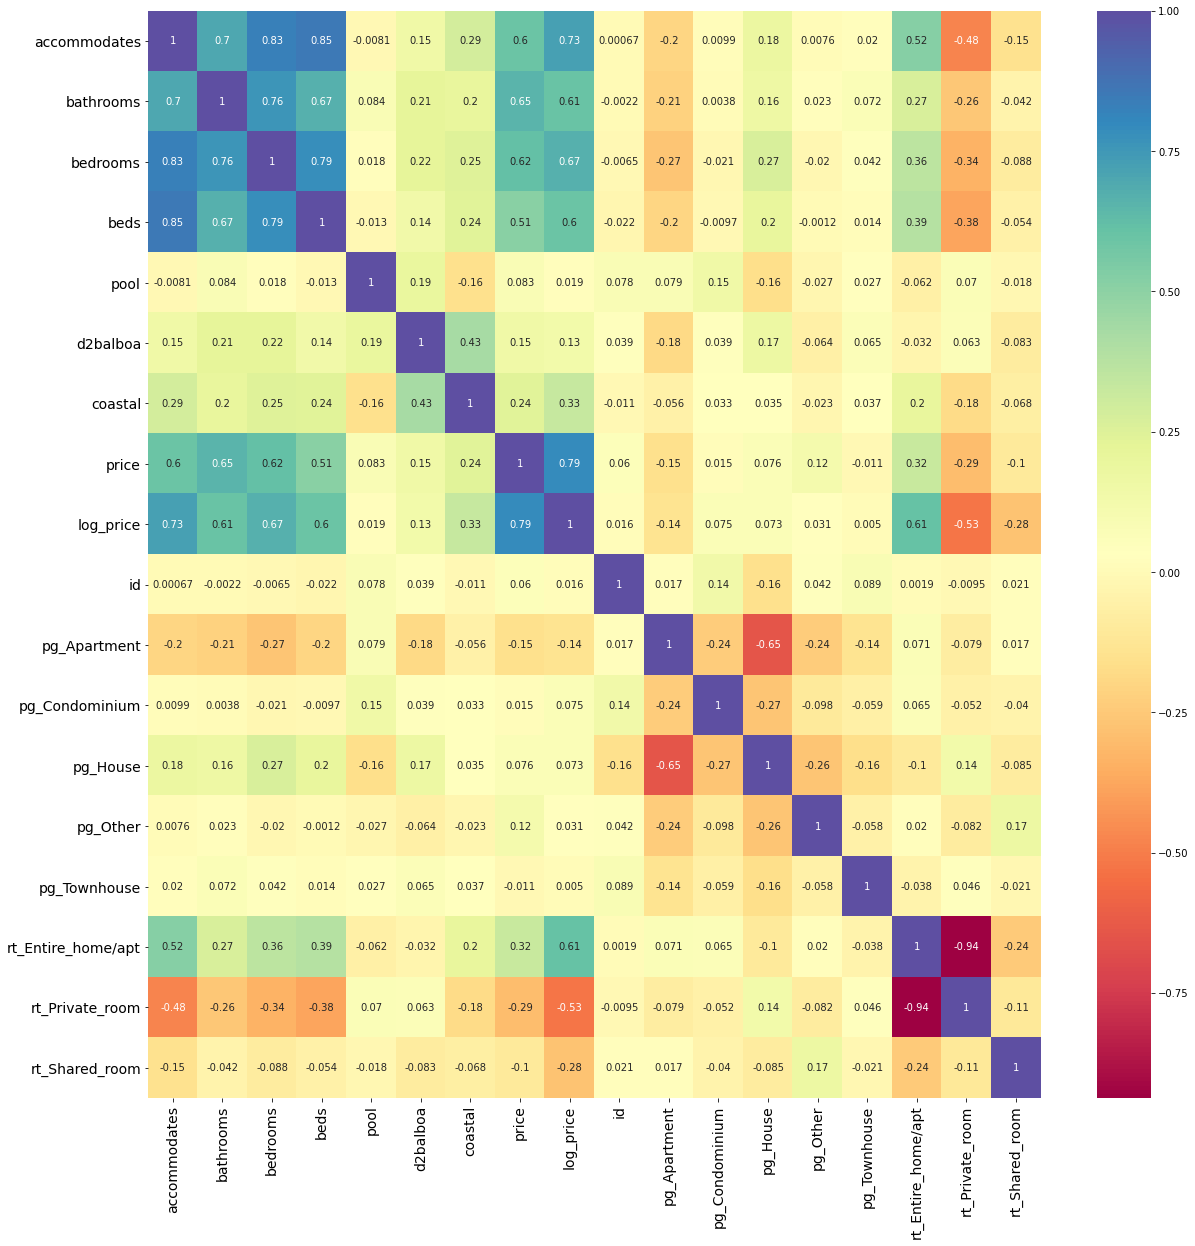

In [13]:
corr=df.corr()
corr_arr=np.array(corr)
col=corr.columns.tolist()
plt.subplots(figsize=(20,20))
sns.heatmap(corr_arr, annot=True, xticklabels=col, yticklabels=col, cmap='Spectral')
plt.xticks(fontsize='14')
plt.yticks(fontsize='14')
plt.show()

####We filter features we want to use going forward based on two factors:
1. High Correlation with log_price (accommodates, bathrooms, bedrooms,beds, 'rt_Private_room')
2. Logical Relational with log_price ('pg_Apartment', 'pg_Condominium', 'pg_House', 'pg_Other', 'pg_Townhouse')

In [38]:
features = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'rt_Private_room', 'rt_Shared_room', 'pg_Condominium', 'pg_House', 'pg_Other', 'pg_Townhouse']

5. Creation of Spatial Regression prelimnary model

We will use the aforementioned variables to determine log_price of the listing

In [39]:
model=spreg.OLS(np.array(df[['log_price']]), np.array(df[features]), name_y='log_price', name_x=features)
print(model.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        6110
Mean dependent var  :      4.9958                Number of Variables   :          11
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6099
R-squared           :      0.6683
Adjusted R-squared  :      0.6678
Sum squared residual:    1320.148                F-statistic           :   1229.0564
Sigma-square        :       0.216                Prob(F-statistic)     :           0
S.E. of regression  :       0.465                Log likelihood        :   -3988.895
Sigma-square ML     :       0.216                Akaike info criterion :    7999.790
S.E of regression ML:      0.4648                Schwarz criterion     :    8073.685

-----------------------------------------------------------------------------

Results

We have obtained an R-squared value of approximately 0.67 which means the model is predicting well for nearly 67% values which is pretty good considering there might be numerous latent factors as well that may have contributed to the setting of a particular price for a property. However, it is worth investigating the residual errors to see why our predictions are still far from ideal. 

6. Investigation of Residuals: Neighborhood wise plots

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


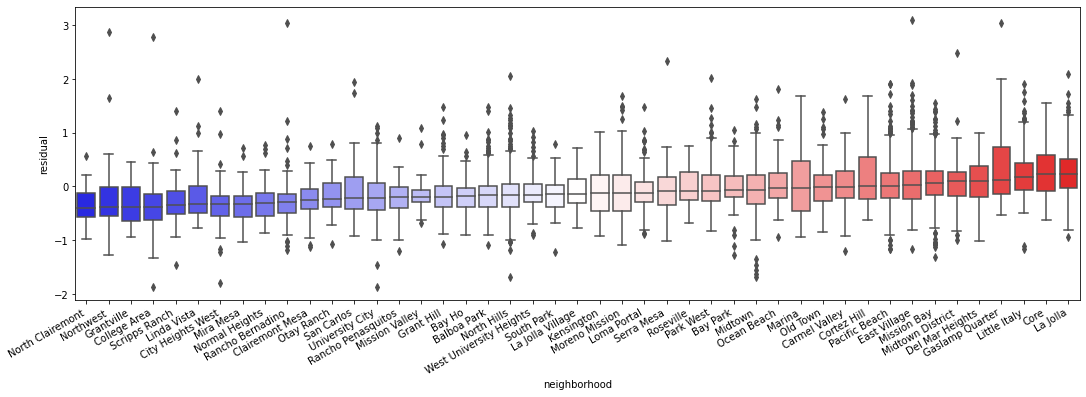

In [86]:
df['residual']=model.u
medians=df.groupby("neighborhood").residual.median().to_frame('res')

fig=plt.figure(figsize=(18,6))
ax=plt.gca()
seaborn.boxplot('neighborhood', 'residual', ax = ax, data=df.merge(medians, how='left', left_on='neighborhood',
                right_index=True).sort_values('res'), palette='bwr')
fig.autofmt_xdate() # will rotate x-ticks for formatting purposes
plt.show()

We can notice in the plot above that are some neighborhoods with extremely low and some with extremely high residuals. And, the ones with lower residuals or the ones with higher residuals tend to be geographically closer / nearby with others in the same categories too. This is an interesting find. Think how some nearby locations might be getting similar kind of predictions even though that might not be correct. 

For example, properties in locations near to each other may compete by offering lower or more economical pricing. Of course, this is a latent attribute and is neither captured by an explicitly stated feature in our dataset or by our model. But this can surely be the reason why we might be experiencing clustering of errors in our predictions.

The simplest way to investigate this further is by visualising the residuals of an observation and its relationship with the residuals of geographicaly surrounding observations.

7. Investigation of Residuals: Using 1 Nearest Neighbor (KNN=1)

In [35]:
knn = weights.KNN.from_dataframe(df, k=1)

/usr/local/lib/python3.7/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 1849 disconnected components.
  warnings.warn(message)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


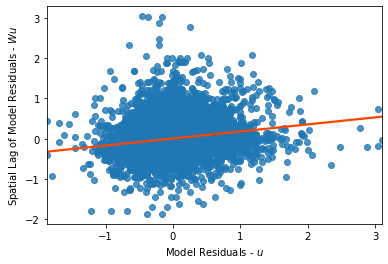

In [87]:
lag_residual = weights.spatial_lag.lag_spatial(knn, model.u)
ax = seaborn.regplot(model.u.flatten(), lag_residual.flatten(), line_kws=dict(color='orangered'),ci=None)
ax.set_xlabel('Model Residuals - $u$')
ax.set_ylabel('Spatial Lag of Model Residuals - $W u$');

The plot above confirms that our errors/residuals tend to cluster confirming our suspicions. 

We can also try visualising when our cluster size is high. However, this is not true if you increase the number of neighborhoods (k in the knn model) which means that this clustering effect seems to die out if proximity of many neighborhoods is concerned. But this does not imply that our residuals are not subject to form clusters. Let’s see what happens if we take k=20. 

8. Investigation of Residuals: Using 20 Nearest Neighbors (KNN=20)

/usr/local/lib/python3.7/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)


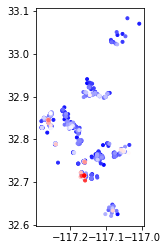

In [89]:
knn.reweight(k=20, inplace=True)
outliers = esda.moran.Moran_Local(model.u, knn, permutations=9999)
error_clusters = (outliers.q % 2 == 1)
error_clusters &= (outliers.p_sim <= .001)
df.assign(error_clusters = error_clusters, local_I = outliers.Is).query("error_clusters").sort_values('local_I').plot('local_I', cmap='bwr', marker='.')

Thus, these areas tend to be locations where our model significantly under-predicts the nightly AirBnB price both for that specific observation and observations in its immediate surroundings. This is critical since, if we can identify how these areas are structured — if they have a consistent geography that we can model — then we might make our predictions even better, or at least not systematically mis-predict prices in some areas while correctly predicting prices in other areas.

9. Creation of Spatial Regression model: Addition of Spatial Heterogeneity

We now add a spatial component to our data by indicating the neighborhood of our listing as a predictor variable.

In [104]:
# PySAL implementation
model_2 = spreg.OLS_Regimes(
    np.array(df[['log_price']]), 
    np.array(df[features]),
    df['neighborhood'].tolist(),
    constant_regi='many',
    cols2regi=[False]*len(features),
    regime_err_sep=False,
    name_y='log_price', 
    name_x=features
)
print(model_2.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES - REGIMES
---------------------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        6110
Mean dependent var  :      4.9958                Number of Variables   :          55
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6055
R-squared           :      0.7118
Adjusted R-squared  :      0.7092
Sum squared residual:    1147.169                F-statistic           :    276.9408
Sigma-square        :       0.189                Prob(F-statistic)     :           0
S.E. of regression  :       0.435                Log likelihood        :   -3559.832
Sigma-square ML     :       0.188                Akaike info criterion :    7229.664
S.E of regression ML:      0.4333                Schwarz criterion     :    7599.137

---------------------------------------------------------

The resulting model provides a significant increase in the value of R squared OLS regression. We jump from 67% to 72% which further confirms the value and importance of spatial data. 

10. Conclusion

After performing the above analysis, it is found that:

- Applying non-spatial regression gives correct results 67% of the time.
- Adding spatial component to the analysis improves the accuracy to 72%                                 

These results indicate that when encountering a geological data, it is better to use spatial regression which can take into account the spatial complexity of the data and help reduce the residual errors that are faced with non-spatial methods.